In [1]:
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import S4
plt.rcParams["font.family"] = "Helvetica"
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


# SPIE (2003)
Repeat the work: Highly efficient polarization independent transmission gratings for pulse stretching and compression.

In [2]:
def binary_grating_spie(d, ff, h, pola, num_basis):
    '''
    Define a function of S4 for calculating the transmittance of 1d binaray gratings.
    args: 
        d: grating period; ff: fill factor, ridge width b/d
        h: groove depth; pola: polarization of incident light
        num_basis: maximum number of in-plane (x and y) Fourier expansion orders
    outputs:
        T: transmittance
    '''
    period = [d, 0]
    S = S4.New(Lattice=((period[0], 0), (0, period[1])), NumBasis=num_basis)
    S.SetMaterial(Name='Air', Epsilon=(1+0j)**2)
    S.SetMaterial(Name='Silica', Epsilon=(1.45+0j)**2)

    S.AddLayer(Name='Air_layer', Thickness=0.1, Material='Air')
    S.AddLayer(Name='Substrate_layer', Thickness=0.1, Material='Silica')
    S.AddLayer(Name='Grating_layer', Thickness=h, Material='Air')
    S.SetRegionRectangle(Layer='Grating_layer', Material='Silica', Center=(
        0, 0), Angle=0, Halfwidths=(ff*d/2, 0))
    S.AddLayer(Name='Bottom_layer', Thickness=0.1, Material='Air')

    lda = 1.06
    angle_inci = np.arcsin(lda/(2*d)) * 180/np.pi
    S.SetExcitationPlanewave(IncidenceAngles=(
        angle_inci, 0), sAmplitude=pola, pAmplitude=1-pola, Order=0)
    S.SetOptions(PolarizationDecomposition=True)
    S.SetFrequency(1/lda)
    powr1 = S.GetPowerFluxByOrder(Layer='Air_layer', zOffset=0)
    powr2 = S.GetPowerFluxByOrder(Layer='Bottom_layer', zOffset=0)

    T = np.abs(np.real(powr2[2][0])) / np.real(powr1[0][0])

    return T


In [3]:
pola = 1.0
num_basis = 13

d_space = np.array([1.350, 1.06, 0.795, 0.55])
h_space = np.linspace(0, 10, 101)
ff_space = np.linspace(0.2, 0.8, 61)
DE_space_TE = np.zeros((len(ff_space), len(h_space), len(d_space)))
DE_space_TM = np.zeros((len(ff_space), len(h_space), len(d_space)))

for k in np.arange(len(d_space)):
    for i in np.arange(len(h_space)):
        for j in np.arange(len(ff_space)):
            DE_space_TE[j, i, k] = binary_grating_spie(d_space[k], ff_space[j], h_space[i], pola, num_basis)
            DE_space_TM[j, i, k] = binary_grating_spie(d_space[k], ff_space[j], h_space[i], 1-pola, num_basis)


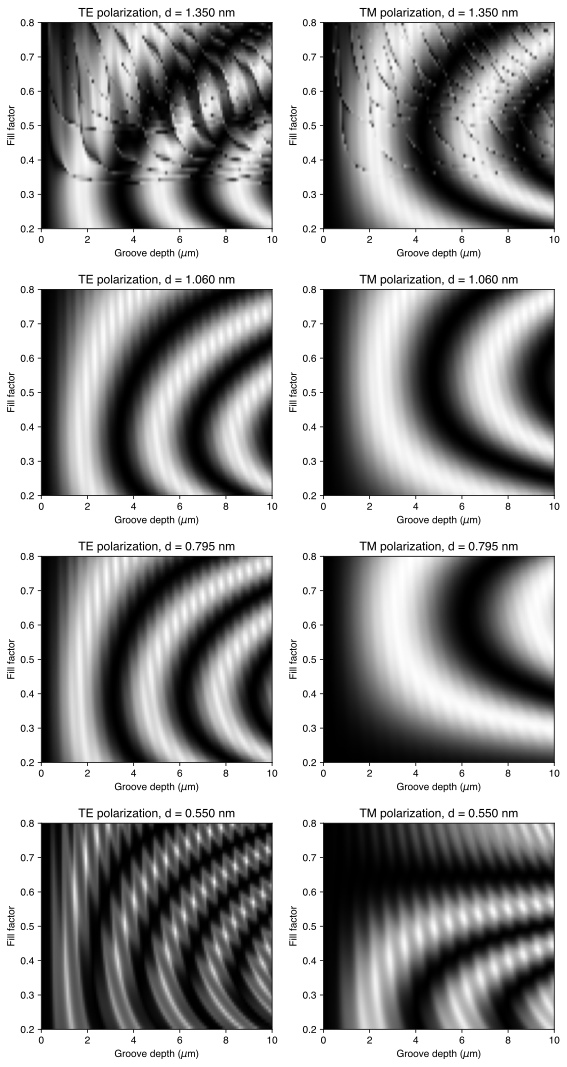

In [4]:
fig, ax = plt.subplots(4, 2, figsize=(8, 15))

for k in np.arange(len(d_space)):
    ax[k][0].imshow(DE_space_TE[:, :, k], aspect='auto', extent=(h_space.min(
    ), h_space.max(), ff_space.min(), ff_space.max()), origin='lower', cmap='gray')
    ax[k][0].set_xlabel(
        'Groove depth ($\mu$m)'), ax[k][0].set_ylabel('Fill factor')
    ax[k][0].set_title(f'TE polarization, d = {d_space[k]:.3f} nm')

    ax[k][1].imshow(DE_space_TM[:, :, k], aspect='auto', extent=(h_space.min(
    ), h_space.max(), ff_space.min(), ff_space.max()), origin='lower', cmap='gray')
    ax[k][1].set_xlabel(
        'Groove depth ($\mu$m)'), ax[k][1].set_ylabel('Fill factor')
    ax[k][1].set_title(f'TM polarization, d = {d_space[k]:.3f} nm')


fig.tight_layout()
plt.show()
